<a href="https://colab.research.google.com/github/meysam-kazemi/drive-unet/blob/main/augment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/RETINAL/

/content/drive/.shortcut-targets-by-id/19v_-z68QIom5bSkKsoiETI2xN8cPjPox/RETINAL


In [ ]:
!ls

augment.ipynb	       presentation.gslides
datasets	       seminar_report_finalـ.docx
figs		       test
files		       test.zip
fr-unet.ipynb	       training
FR-Unet_patches.ipynb  training.zip
kazemi.doc	       unet-2.ipynb
loss_plot.png	       unet.ipynb
models		       unet_model_image-random-patches-finetune-90-final.pth
new_data	       unet_patches.ipynb
outputs


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate, RandomBrightnessContrast

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
    train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))

    test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
    test_y = sorted(glob(os.path.join(path, "test", "mask", "*.gif")))

    return (train_x, train_y), (test_x, test_y)

def augment_data(images, masks, save_path, index=0, augment:bool=True):
    size = (512, 512)

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = imageio.mimread(y)[0]

        if augment:
            aug = HorizontalFlip(p=0.3)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=0.3)
            augmented = aug(image=x1, mask=y1)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug = Rotate(limit=45, p=0.9)
            augmented = aug(image=x2, mask=y2)
            x3 = augmented["image"]
            y3 = augmented["mask"]

            aug = RandomBrightnessContrast(p=0.2)
            augmented = aug(image=x3, mask=y3)
            x4 = augmented["image"]
            y4 = augmented["mask"]

            X = [x4]
            Y = [y4]

        else:
            X = [x]
            Y = [y]

        for i, m in zip(X, Y):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{name}_{index}.png"
            tmp_mask_name = f"{name}_{index}.png"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

""" Seeding """
np.random.seed(42)

""" Load the data """
data_path = "./"
(train_x, train_y), (test_x, test_y) = load_data(data_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

""" Create directories to save the augmented data """
create_dir("new_data/train/image/")
create_dir("new_data/train/mask/")
create_dir("new_data/test/image/")
create_dir("new_data/test/mask/")

""" Data augmentation """
for i in range(20):
  augment_data(train_x, train_y, "new_data/train/", index=i, augment=True)

augment_data(test_x, test_y, "new_data/test/", index=0, augment=False)

Train: 20 - 20
Test: 20 - 20


100%|██████████| 20/20 [00:01<00:00, 15.01it/s]


In [ ]:
%ls new_data/test/image

01_test_0.png  05_test_0.png  09_test_0.png  13_test_0.png  17_test_0.png
02_test_0.png  06_test_0.png  10_test_0.png  14_test_0.png  18_test_0.png
03_test_0.png  07_test_0.png  11_test_0.png  15_test_0.png  19_test_0.png
04_test_0.png  08_test_0.png  12_test_0.png  16_test_0.png  20_test_0.png


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate, RandomBrightnessContrast

def aug(img, mask):
  aug = HorizontalFlip(p=0.3)
  augmented = aug(image=img, mask=mask)
  x1 = augmented["image"]
  y1 = augmented["mask"]

  aug = VerticalFlip(p=0.3)
  augmented = aug(image=x1, mask=y1)
  x2 = augmented["image"]
  y2 = augmented["mask"]

  aug = Rotate(limit=45, p=0.9)
  augmented = aug(image=x2, mask=y2)
  x3 = augmented["image"]
  y3 = augmented["mask"]

  aug = RandomBrightnessContrast(p=0.2)
  augmented = aug(image=x3, mask=y3)
  x4 = augmented["image"]
  y4 = augmented["mask"]

  return x4, y4


In [ ]:
def load_data(path):
    train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
    train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))

    test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
    test_y = sorted(glob(os.path.join(path, "test", "mask", "*.gif")))

    return (train_x, train_y), (test_x, test_y)

(train_x, train_y), (test_x, test_y) = load_data('./')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
train_y

['./training/1st_manual/21_manual1.gif',
 './training/1st_manual/22_manual1.gif',
 './training/1st_manual/23_manual1.gif',
 './training/1st_manual/24_manual1.gif',
 './training/1st_manual/25_manual1.gif',
 './training/1st_manual/26_manual1.gif',
 './training/1st_manual/27_manual1.gif',
 './training/1st_manual/28_manual1.gif',
 './training/1st_manual/29_manual1.gif',
 './training/1st_manual/30_manual1.gif',
 './training/1st_manual/31_manual1.gif',
 './training/1st_manual/32_manual1.gif',
 './training/1st_manual/33_manual1.gif',
 './training/1st_manual/34_manual1.gif',
 './training/1st_manual/35_manual1.gif',
 './training/1st_manual/36_manual1.gif',
 './training/1st_manual/37_manual1.gif',
 './training/1st_manual/38_manual1.gif',
 './training/1st_manual/39_manual1.gif',
 './training/1st_manual/40_manual1.gif']

In [ ]:
ys = []
xs = []
for i in range(4):
  x = cv2.imread(train_x[i])[...,::-1]
  y = imageio.mimread(train_y[i])[0]
  xs.append(x)
  ys.append(y)

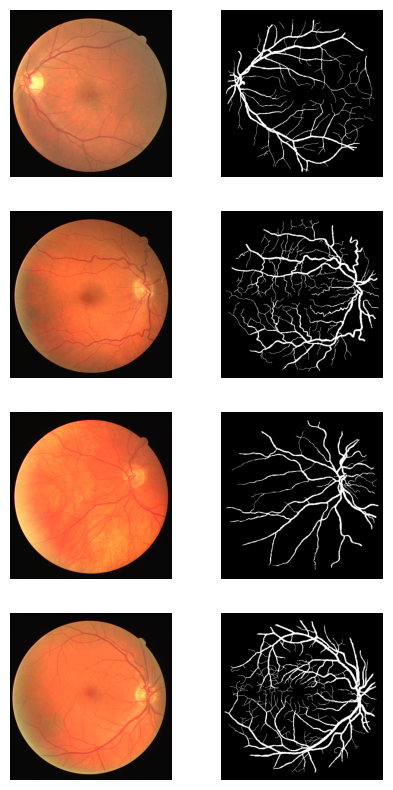

In [ ]:
f, axs = plt.subplots(4,2, figsize=(5,10))
for i, ax_row in enumerate(axs):
  ax_row[0].imshow(xs[i]);ax_row[0].axis(False)
  ax_row[1].imshow(ys[i], 'gray');ax_row[1].axis(False)


In [ ]:
f.savefig('figs/drive_dataset.png')

Text(0.5, 1.0, 'augmented mask')

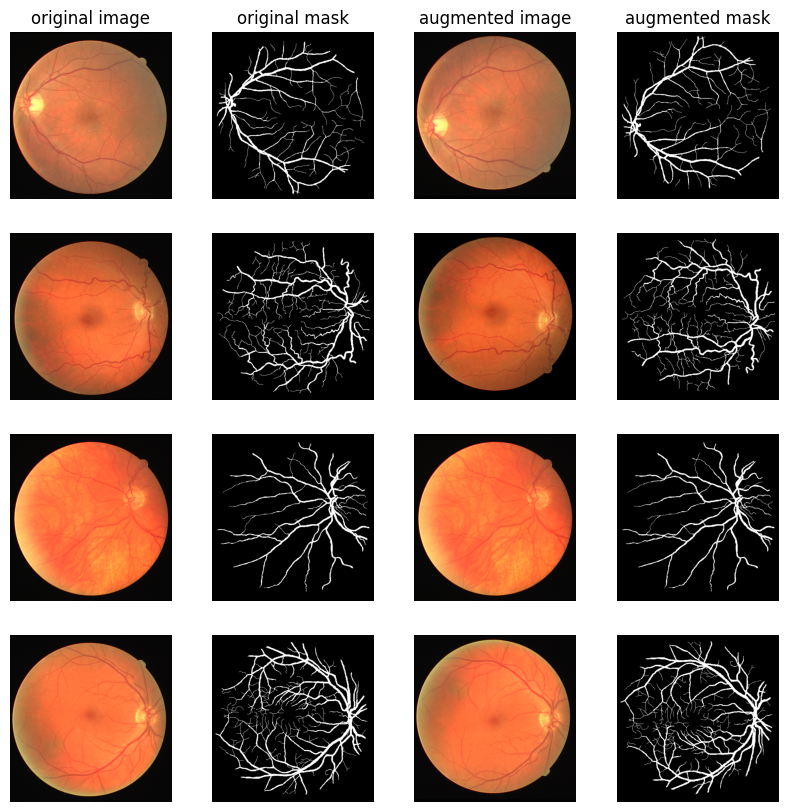

In [ ]:

def aug(img, mask):
  aug = HorizontalFlip(p=0.3)
  augmented = aug(image=img, mask=mask)
  x1 = augmented["image"]
  y1 = augmented["mask"]

  aug = VerticalFlip(p=0.3)
  augmented = aug(image=x1, mask=y1)
  x1 = augmented["image"]
  y1 = augmented["mask"]

  # aug = Rotate(limit=45, p=0.9)
  # augmented = aug(image=x1, mask=y1)
  # x1 = augmented["image"]
  # y1 = augmented["mask"]

  aug = RandomBrightnessContrast(p=0.2)
  augmented = aug(image=x1, mask=y1)
  x1 = augmented["image"]
  y1 = augmented["mask"]

  return x1, y1


f, axs = plt.subplots(4,4, figsize=(10,10))
for i, ax_row in enumerate(axs):
  ax_row[0].imshow(xs[i]);ax_row[0].axis(False)
  ax_row[1].imshow(ys[i], 'gray');ax_row[1].axis(False)
  X, Y = aug(xs[i], ys[i])
  ax_row[2].imshow(X);ax_row[2].axis(False)
  ax_row[3].imshow(Y, 'gray');ax_row[3].axis(False)

axs[0,0].set_title("original image")
axs[0,1].set_title("original mask")
axs[0,2].set_title("augmented image")
axs[0,3].set_title("augmented mask")

In [ ]:
f.savefig('figs/drive_dataset_augmented.png')

In [ ]:
images = sorted(glob("datasets/DRIVE/patches/train/images/*"))
masks = sorted(glob("datasets/DRIVE/patches/train/masks/*"))

xs = []
ys = []
for i in range(16):
  xs.append(cv2.imread(images[i])[...,::-1])
  ys.append(imageio.mimread(masks[i])[0])

In [ ]:
xs[1].shape

(128, 128, 3)

In [ ]:
len(xs)

16

(-0.5, 541.5, 541.5, -0.5)

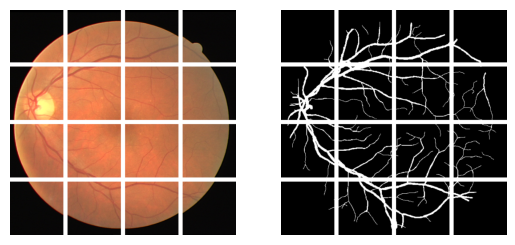

In [ ]:
image = np.ones((542,542,3), dtype="uint8")*255
image[:128,:128, :] = xs[0]
for i in range(4):
  for j in range(4):
    startx, endx = i*128+10*i, i*128+128+10*i
    starty, endy = j*128+10*j, j*128+128+10*j
    image[startx:endx, starty:endy,:] = xs[i*4+j]

mask = np.ones((542,542,3), dtype="uint8")*255
mask[:128,:128, :] = xs[0]
for i in range(4):
  for j in range(4):
    startx, endx = i*128+10*i, i*128+128+10*i
    starty, endy = j*128+10*j, j*128+128+10*j
    mask[startx:endx, starty:endy,:] = ys[i*4+j]

fig = plt.figure()
plt.subplot(1,2,1)
plt.imshow(image);plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(mask, 'gray');plt.axis(False)

In [ ]:
fig.savefig("figs/patches.png")